In [54]:
# Imports

import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import os,sys,datetime,warnings,time,math,itertools

import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

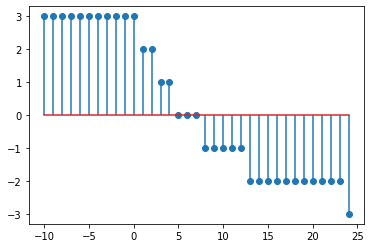

In [55]:
# Params

# Initial Case Value
R0 = 2
# Minimal Case Value, in case never solved
Rinf = -3
# Time until which reward function turns penalty function, i.e. the zero of reward function [days]
Tpenalty = 5

# Derived quantities

# Reward Range
Rr = R0 - Rinf
# Kappa measures decay, base for the exponential - selected from parameters such that above zero and limits are reached
kappa = np.exp(-np.log(1-R0/Rr)/Tpenalty)

# Penalty Function
f = lambda x: np.round((R0 - Rr*(1 - kappa**(-np.max([0,x])+1))))

days = np.arange(-10,25)
penalty = [f(d) for d in days]

plt.stem(days,penalty)
plt.show()

In [26]:
# Assign case to person
def assign_case(casenameK,ownerK):
    # Case 1 assigned to Olga
    assert tables[2].at[tables[2][tables[2]['K:Casename']==casenameK].index[0],'FK:Owner'] is None,'Case is blocked by other owner'
    tables[2].at[tables[2][tables[2]['K:Casename']==casenameK].index[0],'FK:Owner'] = ownerK
    tables[4].loc[len(tables[4].index)] = [casenameK,ownerK,D,None,R0]
    # Done
    return

In [27]:
# Change Case Values over time
def update_casevalues():
    # Run update
    #tables[4]['Case Value'] = tables[4][['Case Value','Assignment Day','Resolution Day']].apply(lambda x: (x[0] if D - x[1]>2 else x[0]-(D-x[1])) if x[2] is None else x[0],axis=1)
    tables[4]['Case Value'] = tables[4][[
        'Case Value',
        'Assignment Day',
        'Resolution Day'
    ]].apply(
        lambda x: 
            np.round((R0 - Rr*(1 - kappa**(-1*((D-x[1])+1)))))
            if x[2] is None else x[0]
    ,axis=1)
    # Done
    return

In [28]:
# Set an assigned case to solved
def solve_case(caseName,solverName):
    caseIdx = tables[4][
        (tables[4]['FK:Casename']==caseName)&
        (tables[4]['FK:Assignee Name']==solverName)
    ].index[0]
    solverIdx = tables[0][tables[0]['K:Name']==solverName].index[0]
    # Exit if Rule already resolved
    assert tables[4].at[0,'Resolution Day'] is None,'Case is already resolved'
    # Store current day as resolution day
    tables[4].at[
        caseIdx,
        'Resolution Day'
    ] = D
    # Instantiate current reward
    tables[0].at[solverIdx,'Value'] += tables[4].loc[caseIdx,'Case Value']
    # Done 
    return


In [29]:
# Function to move to next day globally, stores historized version of all tables
def nextday():
    global D 
    # Iterate all tables
    for tablepointer in tables_metadata.keys():
        # Get current table status
        tf = tables[tablepointer].copy()
        # If table empty, attach dummy entry
        if tables[tablepointer].shape[0]==0:
            tf = pd.DataFrame([[None]*tables[tablepointer].shape[1]],columns=tables[tablepointer].columns)
        # Add day
        tf['H:Status Day'] = D
        # Append new day status to history table
        tables_h[tablepointer] = pd.concat([tables_h[tablepointer],tf])
    D = D + 1
    # Update case values
    update_casevalues()
    # Done
    return

In [53]:
# Plot total market values
def plot_totals(storepath='./data/images/'):
    # Merge case values with real capital to create visualization file
    if tables[4].shape[0]!=0:
        tf = tables[0].copy().merge(
            tables[4][tables[4]['Resolution Day'].isna()].groupby(['FK:Assignee Name'],as_index=False)['Case Value'].sum(),
            left_on='K:Name',right_on='FK:Assignee Name',
            how='left'
        ).rename(columns={'Case Value':'Case Values Aggregate'}).drop(columns=['FK:Assignee Name'])
        tf['Case Values Aggregate'] = tf['Case Values Aggregate'].fillna(0)
        tf['Total Value Participant'] = tf['Value'] + tf['Case Values Aggregate']
    else:
        tf = tables[0].copy()
        tf['Total Value Participant'] = tf['Value']
    # Create pie chart
    fig = make_subplots(rows=1,cols=2,specs=[[{'type':'pie'},{'type':'pie'}]])
    # Plot Value Totals, including the assigned cases revenue
    fig.add_trace(
        go.Pie(
            labels=tf['K:Name'].tolist(),
            values=tf['Total Value Participant'].tolist()
        ),
        row=1,col=1
    )
    # Plot real market value
    fig.add_trace(
        go.Pie(
            labels=tf['K:Name'].tolist(),
            values=tf['Value'].tolist()
        ),
        row=1,col=2
    )
    # Prettify plot
    fig.update_traces(
        hoverinfo='label+percent',
        textinfo='value',
        textfont_size=20,
    )
    fig.update_layout(
        title='Day {0}: Total Market Value = {1:.1f}   --   Real Market Value = {2:.1f}'.format(D,float(tf['Total Value Participant'].sum()),float(tf['Value'].sum()))
    )
    # Plot figure
    fig.show()
    # Prepare empty storage directory
    if not os.path.exists(storepath): os.mkdir(storepath)
    # Store figure
    fig.write_image(storepath+'totals_day{0}.jpeg'.format(D))
    # Done
    return

In [31]:
# Subscribe some person to a rule
def subscribe_person(nameK,ruleK):
    # Extract Owner of Rule
    ownerK = tables[1][tables[1]['K:Rule']=='Svens gorgeous rule']['Owner'].values[0]
    # Subscription
    tables[3].loc[len(tables[3].index)] = [nameK,ruleK,D]
    # Payment for subscription
    tables[0].at[tables[0][tables[0]['K:Name']==nameK].index[0],'Value'] -= sB
    tables[0].at[tables[0][tables[0]['K:Name']==ownerK].index[0],'Value'] += sB
    # Done
    return

In [25]:
# Declare globals

# Global day counter
global D

In [32]:
# Initialize tables
tables_metadata = {
    0:'Market Participants (K:Name -- Status -- Value)',
    1:'Rules (Birthday -- K:Rule -- Owner -- Prize)',
    2:'Cases (Birthday -- K:Casename -- FK:Origin Rule -- Resolution Premium by Owner -- FK:Owner)',
    3:'Subscriptions (FK:Name -- FK:Rule -- Subscription Day)',
    4:'Casework (FK:Casename -- FK:Assignee Name -- Assignment Day -- Resolution Day -- Case Value)'
}

# Master Data consists of marketplace participants, ruleset and cases
# Relationships exist between rules and subscribers, and cases and assignees
tables = [

    pd.DataFrame(columns=['K:Name','Status','Value']),
    pd.DataFrame(columns=['Birthday','K:Rule','Owner','Prize']),
    pd.DataFrame(columns=['Birthday','K:Casename','FK:Origin Rule','Resolution Premium by Owner','FK:Owner']),
    pd.DataFrame(columns=['FK:Name','FK:Rule','Subscription Day']),
    pd.DataFrame(columns=['FK:Casename','FK:Assignee Name','Assignment Day','Resolution Day','Case Value'])
]

# History Files created by files with Status day attached
tables_h = [
    pd.DataFrame(columns=['H:Status Day','K:Name','Status','Value']),
    pd.DataFrame(columns=['H:Status Day','Birthday','Owner','K:Rule']),
    pd.DataFrame(columns=['H:Status Day','Birthday','K:Casename','FK:Origin Rule','Resolution Premium by Owner','FK:Owner']),
    pd.DataFrame(columns=['H:Status Day','FK:Name','FK:Rule','Subscription Day']),
    pd.DataFrame(columns=['H:Status Day','FK:Casename','FK:Assignee Name','Assignment Day','Resolution Day','Case Value'])
]

In [33]:
# Empty directory
target_storepath = './data/images/'
filelist = [f for f in os.listdir(target_storepath) if f.endswith('.jpeg')]
for f in filelist:
    os.remove(os.path.join(target_storepath,f))

# Initial day
D = 0

# Initial Capital
iB = 5

# Subscription Fee
sB = 1

# Initial case value
R0 = 2
# Maximum penalty for unsolved cases
Rinf = -3
# Time in days until which reward function turns penalty function
Tpenalty = 5
# Range across which reward/penalty moves
Rr = R0 - Rinf
# Base for exponential decay function
kappa = np.exp(-np.log(1-R0/Rr)/Tpenalty)

# Day 0
Four participants enter the market, each gets their initial beardollars.

In [34]:
# Create four market participants
tables[0].loc[0] = ['Sven','Analytics Stakeholder',iB]
tables[0].loc[1] = ['Olga','Data Owner',iB]
tables[0].loc[2] = ['Claire','Data Owner',iB]

In [35]:
plot_totals()
nextday()

# Day 1
Participant launches a new rule, no subscribers yet

In [36]:
tables[1].loc[len(tables[1].index)] = [D,'Svens gorgeous rule','Sven',0]

In [37]:
plot_totals()
nextday()

# Day 2
New Rule generates four cases. Other participant discovers rule, subscribes and assigns self a case.

In [38]:
# Cases
tables[2].loc[len(tables[2].index)] = [D,'Svenrule case 1','Svens gorgeous rule',0,None]

In [39]:
subscribe_person('Olga','Svens gorgeous rule')

In [40]:
assign_case('Svenrule case 1','Olga')

In [41]:
plot_totals()

In [42]:
nextday()

# Day 3
Olga solved the assigned case, creating _real value_ and materializing the investment. Since she's one day late, she only gains one token in value from it 

In [43]:
solve_case('Svenrule case 1','Olga')

In [44]:
plot_totals()

In [45]:
nextday()

In [46]:
plot_totals()